In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, unicodedata
import inflect
import ast
import re
import json

In [2]:
# remove URLS, numbers

def remove_URL(sample):
    """Remove URLs from a sample string"""
    new_words = []
    for word in sample:
        if (re.sub(r"http\S+", "", word) != ''):
            new_words.append(word)
    return new_words

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words



def clean_text(tokens):
    new_words = []
    emoji_pat = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
    shrink_whitespace_reg = re.compile(r'\s{2,}')
    for word in tokens:
      reg = re.compile(r'({})|[^a-zA-Z]'.format(emoji_pat)) # line a
      result = reg.sub(lambda x: ' {} '.format(x.group(1)) if x.group(1) else '', word)
      if(result != ''):
        new_words.append(shrink_whitespace_reg.sub(' ', result))
    return new_words

In [4]:
df_NLP = pd.read_csv('/content/drive/MyDrive/WSB/wsb_submissions_NLP_clean.csv')
df_features = pd.read_csv('/content/drive/MyDrive/WSB/WSB_submissions_with_sentiment.csv',sep=';')

In [5]:
#get link_flair_text,	num_comments,	score,upvote_ratio
df_NLP = pd.merge(df_NLP,df_features[['id','link_flair_text',	'num_comments',	'score','upvote_ratio']],on='id',how='left')

In [6]:
df_NLP.drop('Unnamed: 0',inplace=True,axis=1)

In [7]:
df_NLP.head()

created_utc      id  ... score upvote_ratio
0  2021-10-19 17:58:57  qbh10s  ...     1          1.0
1  2021-10-19 17:57:49  qbh04w  ...     1          1.0
2  2021-10-19 17:55:24  qbgyco  ...     1          1.0
3  2021-10-19 17:54:51  qbgxy8  ...     1          1.0
4  2021-10-19 17:52:33  qbgw9u  ...     1          1.0

[5 rows x 10 columns]

In [8]:
test = df_NLP.loc[:10,'title_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
test = df_NLP.loc[:10,'selftext_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
test

0     [cad, bb, move, gain, traction, get, ape, brai...
1                                                    []
2                                                    []
3                                                    []
4     [bb, move, higher, patent, alone, come, pipeli...
5                                                    []
6                                                    []
7                                                    []
8                                                    []
9     [nerd, long, time, post, come, bearing, gift, ...
10    [tsla, beating, estimate, delivery, earnings, ...
Name: selftext_lemmatized, dtype: object

In [9]:
df_NLP['title_lemmatized'] = df_NLP['title_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
df_NLP['selftext_lemmatized'] = df_NLP['selftext_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))

In [10]:
words =  df_NLP['title_lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords[0:50])


['bb', 'surely', 'coincidence', 'yolo', 'sava', 'option', 'meme', 'bb', 'sdig', 'sit', 'ape', 'strong', 'charging', 'bull', 'inspiration', 'prog', 'yolo', 'yr', 'menace', 'hedge', 'fund', 'squeeze', 'short', 'hood', 'k', 'gain', 'tsla', 'delivery', 'preearnings', 'tpx', 'look', 'one', 'future', 'help', 'bite', 'lol', ' 😂 ', 'know', 'something', 'genuis', ' 💎 🏾 ', 'bb', ' 🚀 🚀 🚀 🚀 🚀 ', 'serious', 'question', 'try', 'understand', 'amc', 'gme', 'still']


In [11]:
words =  df_NLP['selftext_lemmatized']
allwords_selftext = []
for wordlist in words:
    allwords_selftext += wordlist
print(allwords_selftext[0:50])

['cad', 'bb', 'move', 'gain', 'traction', 'get', 'ape', 'brain', 'move', 'one', 'late', 'buy', 'black', 'berry', 'make', 'move', 'bb', 'move', 'higher', 'patent', 'alone', 'come', 'pipeline', 'holder', 'stock', 'also', 'strong', 'believer', 'stock', 'year', 'hold', 'tight', 'nerd', 'long', 'time', 'post', 'come', 'bearing', 'gift', 'knowledge', 'whatever', 'knowledge', 'the', 'knowledge', 'hood', 'get', 'prim', 'massive', 'short', 'squeeze']


In [12]:
type(allwords_selftext)

list

In [13]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df_NLP['title_lemmatized'])
# Create Corpus
texts = df_NLP['title_lemmatized']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2][0][:30])

[(0, 1)]


In [14]:
from pprint import pprint
import gensim
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"short" + 0.028*"bet" + 0.015*"street" + 0.014*"wall" + '
  '0.014*"happen" + 0.012*"gold" + 0.012*"daddy" + 0.011*"real" + '
  '0.010*"squeeze" + 0.009*"autism"'),
 (1,
  '0.100*"buy" + 0.047*"sell" + 0.037*"robinhood" + 0.023*"trading" + '
  '0.020*"option" + 0.016*"share" + 0.016*"dip" + 0.015*"stock" + 0.015*" 🌈 🐻 '
  '" + 0.013*"anyone"'),
 (2,
  '0.029*"money" + 0.028*"like" + 0.025*"go" + 0.024*"make" + 0.021*"think" + '
  '0.021*"guy" + 0.020*"get" + 0.018*"know" + 0.015*"stock" + 0.015*"look"'),
 (3,
  '0.085*"go" + 0.084*"k" + 0.048*"u" + 0.041*"yolo" + 0.036*"pltr" + '
  '0.036*"moon" + 0.025*"let" + 0.023*"fuck" + 0.022*"gme" + 0.022*" 🚀 "'),
 (4,
  '0.063*"tsla" + 0.022*"stonks" + 0.019*"market" + 0.015*"monday" + 0.014*"s" '
  '+ 0.013*"covid" + 0.012*"trump" + 0.011*"free" + 0.008*"split" + '
  '0.008*"god"'),
 (5,
  '0.055*"market" + 0.044*"stock" + 0.015*"future" + 0.015*"news" + '
  '0.015*"big" + 0.015*"move" + 0.014*"play" + 0.013*"new" + 0.013*"trader

In [ ]:
#Visualize LDA

## Selftext

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(df_NLP['selftext_lemmatized'])
# Create Corpus
texts = df_NLP['selftext_lemmatized']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1)]


In [16]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"gt" + 0.030*"spy" + 0.028*"p" + 0.016*"chart" + 0.016*"earnings" + '
  '0.014*"s" + 0.012*"week" + 0.011*"http" + 0.010*"index" + 0.009*"move"'),
 (1,
  '0.036*"vaccine" + 0.028*"covid" + 0.017*"virus" + 0.016*"trial" + '
  '0.016*"test" + 0.016*"drug" + 0.013*"patient" + 0.012*"phase" + 0.010*"fda" '
  '+ 0.010*"result"'),
 (2,
  '0.025*"go" + 0.017*"get" + 0.013*"make" + 0.012*"like" + 0.011*"fuck" + '
  '0.011*"money" + 0.010*"know" + 0.009*"shit" + 0.008*"think" + 0.008*"u"'),
 (3,
  '0.299*"amp" + 0.105*"http" + 0.067*"xb" + 0.034*"width" + 0.034*"autowebp" '
  '+ 0.028*"formatpng" + 0.025*"qflair" + 0.025*"restrictsron" + 0.023*"https" '
  '+ 0.021*"best"'),
 (4,
  '0.023*"call" + 0.021*"buy" + 0.019*"stock" + 0.019*"price" + 0.017*"share" '
  '+ 0.015*"go" + 0.015*"sell" + 0.014*"c" + 0.011*"day" + 0.011*"option"'),
 (5,
  '0.023*"company" + 0.013*"tesla" + 0.006*"apple" + 0.006*"product" + '
  '0.006*"car" + 0.006*"https" + 0.006*"new" + 0.006*"s" + 0.006*"techno

## Word Clouds of Top N Keywords in Each Topic

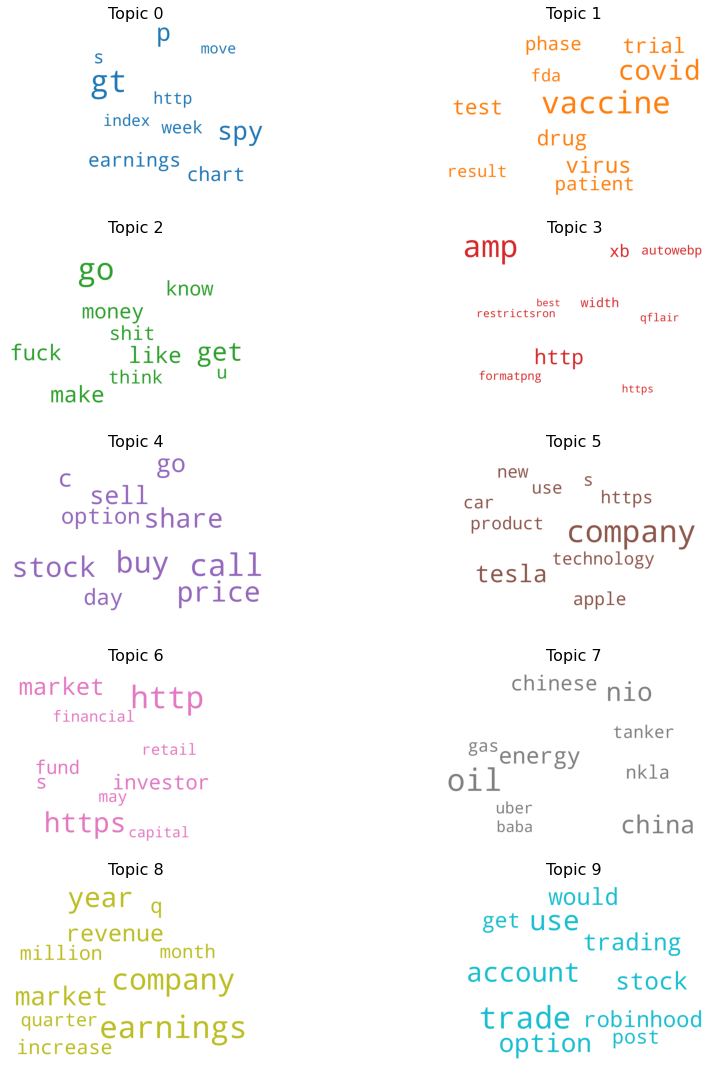

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 
                    'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                   'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may',
                   'take', 'come','amp','http','https','width'])

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)


for i, ax in enumerate(axes.flatten()):
    
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

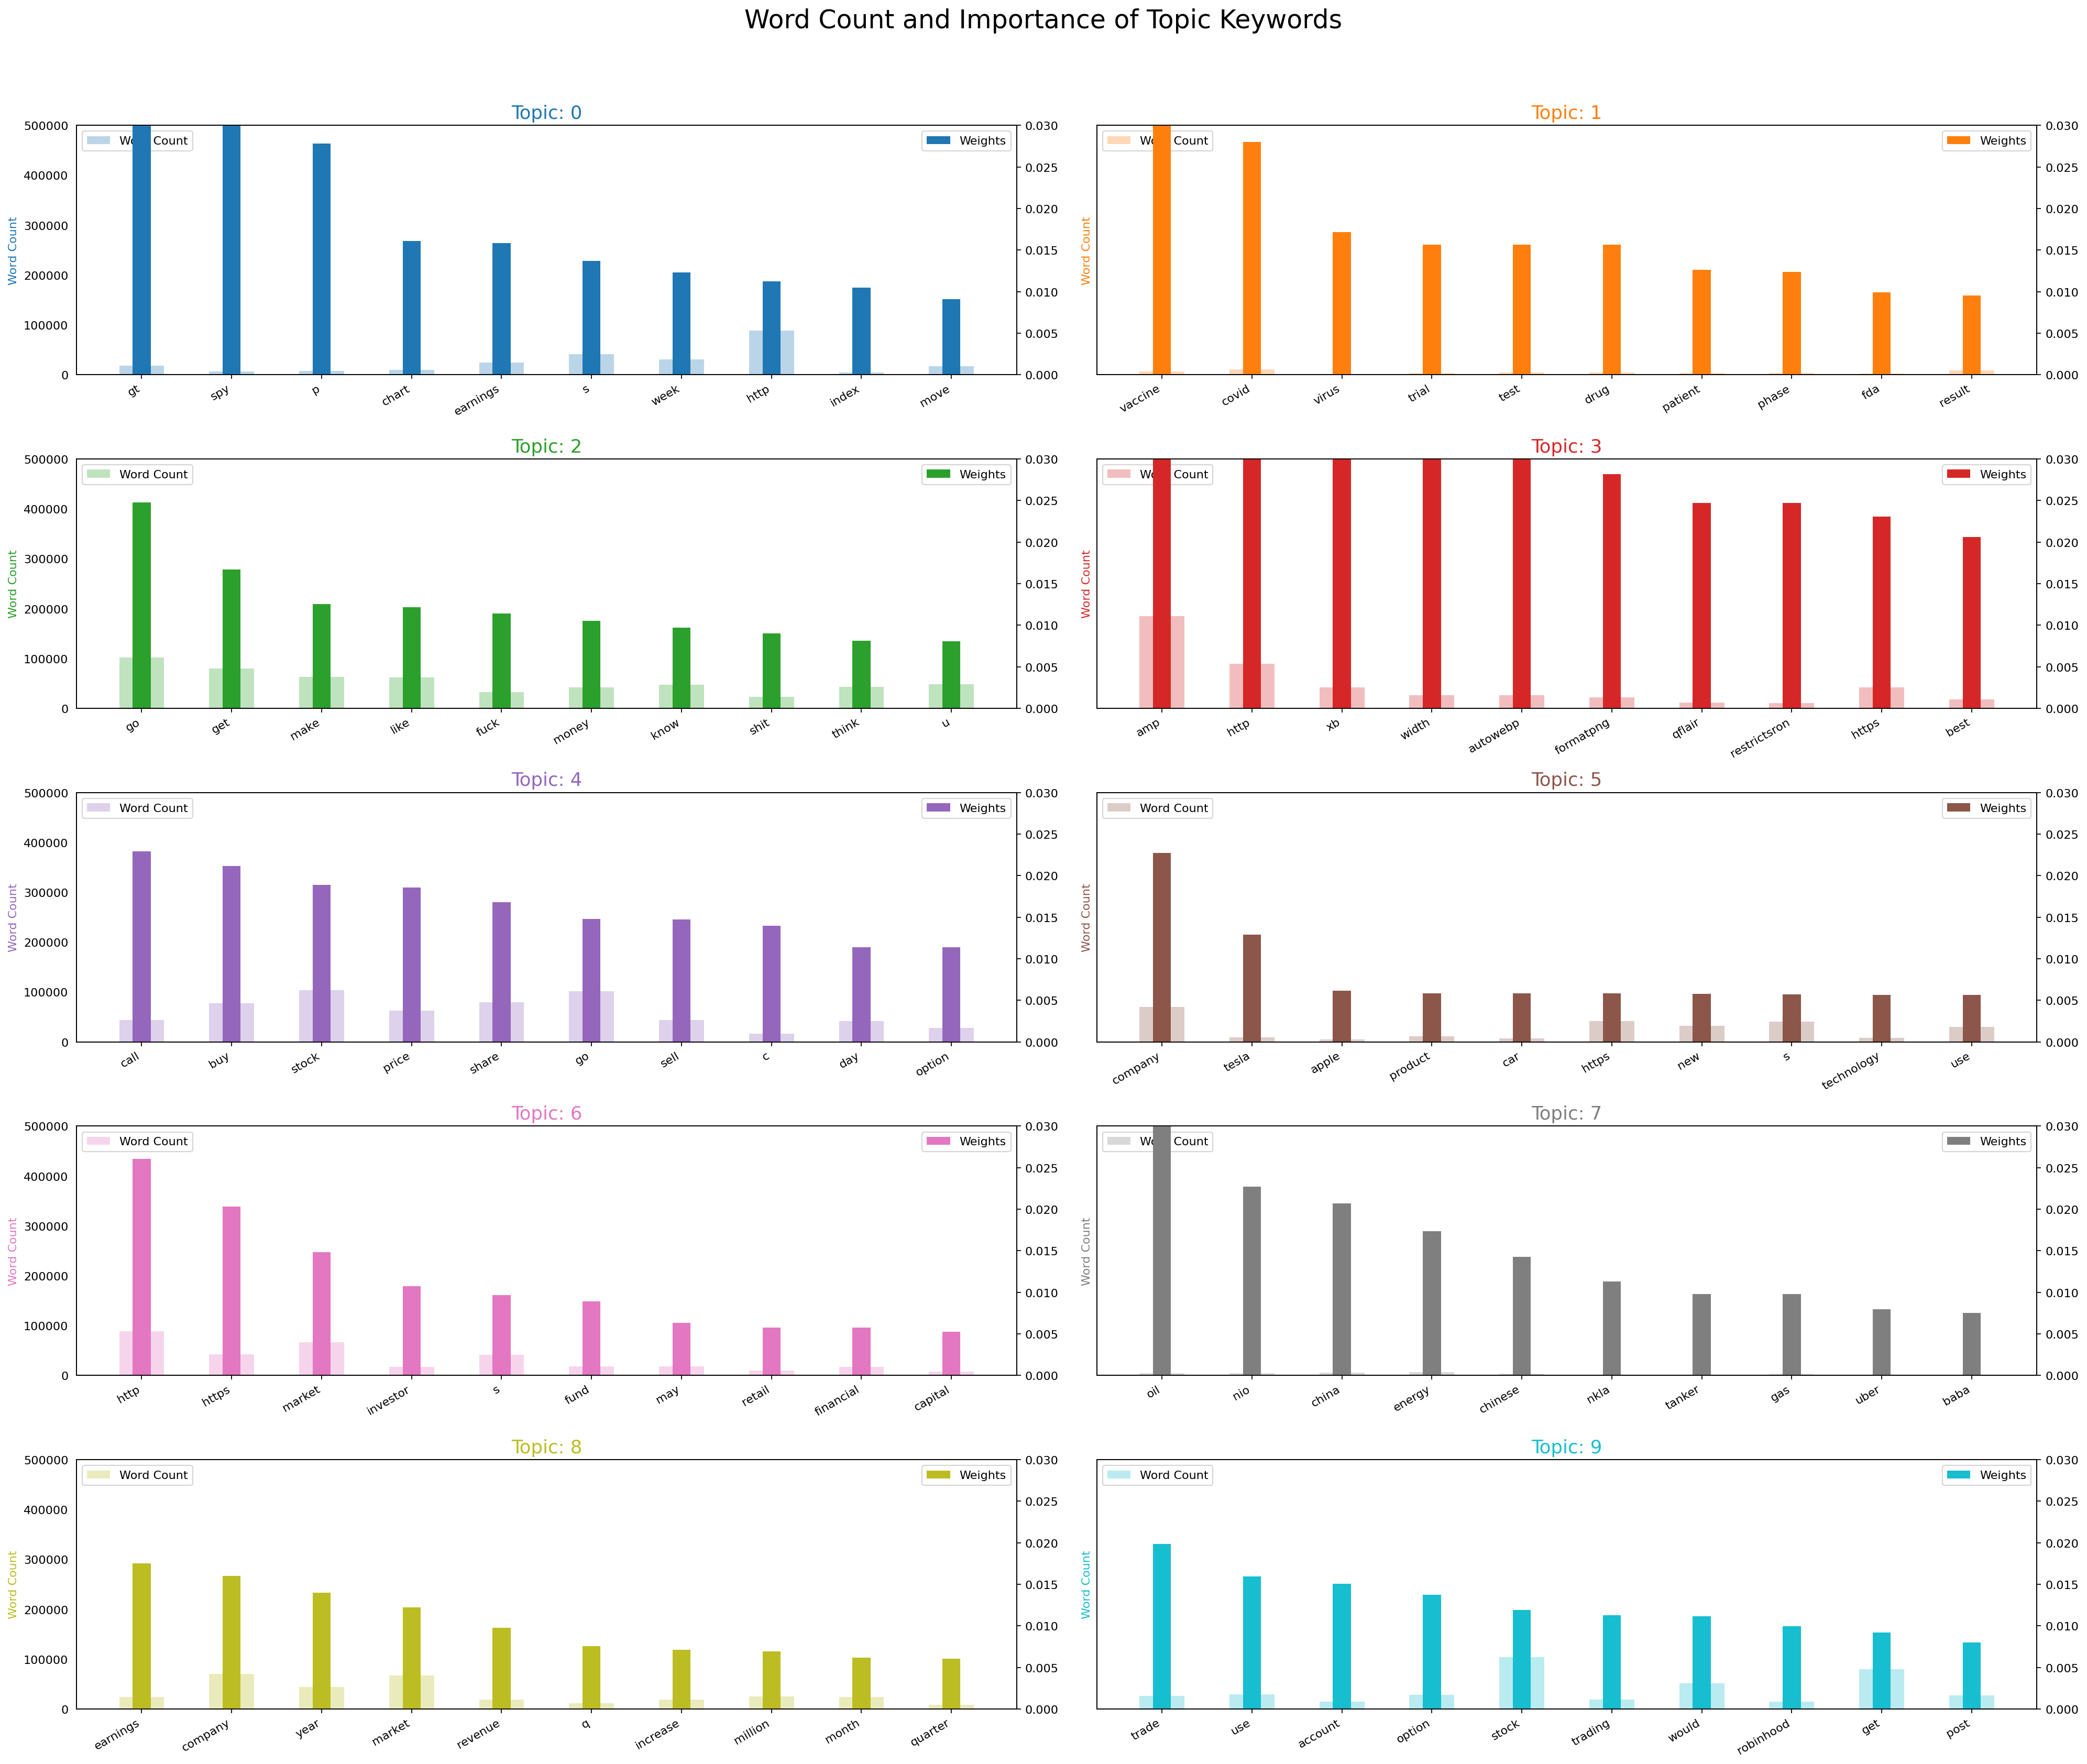

In [43]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(25,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 500000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [50]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    #print([w for i, w in row_list])
    #break
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 161158 samples in 0.328s...
[t-SNE] Computed neighbors for 161158 samples in 17.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 161158
[t-SNE] Computed conditional probabilities for sample 2000 / 161158
[t-SNE] Computed conditional probabilities for sample 3000 / 161158
[t-SNE] Computed conditional probabilities for sample 4000 / 161158
[t-SNE] Computed conditional probabilities for sample 5000 / 161158
[t-SNE] Computed conditional probabilities for sample 6000 / 161158
[t-SNE] Computed conditional probabilities for sample 7000 / 161158
[t-SNE] Computed conditional probabilities for sample 8000 / 161158
[t-SNE] Computed conditional probabilities for sample 9000 / 161158
[t-SNE] Computed conditional probabilities for sample 10000 / 161158
[t-SNE] Computed conditional probabilities for sample 11000 / 161158
[t-SNE] Computed conditional probabilities for sample 12000 / 161158
[t-SNE] Computed conditional probab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.530396
[t-SNE] KL divergence after 1000 iterations: 3.119730
